In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import datasets

dataset = datasets.load_iris()
dataset = pd.DataFrame(data= np.c_[dataset['data'], dataset['target']], columns= dataset['feature_names'] + ['target'])
# replace target values with target names
dataset['target'] = dataset['target'].replace({0: 'setosa', 1: 'versicolor', 2: 'virginica'})


### Dividindo em Teste e Treino

Vamos examinar algumas estratégias que devemos considerar para avaliar o desempenho dos modelos que iremos desenvolver.

1. **Estratégia 1**

<center>
A estratégia de separação mais básica, dividindo o conjunto de dados original em Treinamento e Teste.
</center>

<figure>
<center>
<img src='https://developers.google.com/machine-learning/crash-course/images/PartitionTwoSets.svg' />
<img src='https://developers.google.com/machine-learning/crash-course/images/WorkflowWithTestSet.svg' />
<figcaption>Avaliamos o desempenho no conjunto de teste e escolhemos o melhor resultado com base nisso [2, 3].</figcaption></center>
</figure>

2. **Estratégia 2**

<center>
Uma estratégia mais robusta, dividindo o conjunto de dados original em Treinamento, Validação e Teste.
</center>

<figure>
<center>
<img src='https://developers.google.com/machine-learning/crash-course/images/PartitionThreeSets.svg' />
<img src='https://developers.google.com/machine-learning/crash-course/images/WorkflowWithValidationSet.svg' />
<figcaption>Avaliamos o desempenho no conjunto de validação e escolhemos o melhor resultado com base nisso [2, 3].</figcaption></center>
</figure>

[[2] - Referência da Figura](https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data)

[[3] - Referência da Figura](https://developers.google.com/machine-learning/crash-course/validation/another-partition)



In [ ]:
train, test = train_test_split(dataset, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

target = 'target'
features = [col for col in dataset.columns if col != target]

x_train = train[features]
y_train = train[target]
x_val = val[features]
y_val = val[target]
x_test = test[features]
y_test = test[target]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators=10, random_state=42)

model.fit(x_train, y_train)
y_pred = model.predict(x_val)



accuracy = accuracy_score(y_val, y_pred)


In [ ]:
# confusion matrix

from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_val, y_pred)

# plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [ ]:
import pickle

with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [ ]:
# train second model

model_2 = RandomForestClassifier(n_estimators=50, random_state=42)

model.fit(x_train, y_train)
y_pred = model.predict(x_val)

accuracy = accuracy_score(y_val, y_pred)

conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
# dump second model
with open('model_2.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

## Tracking

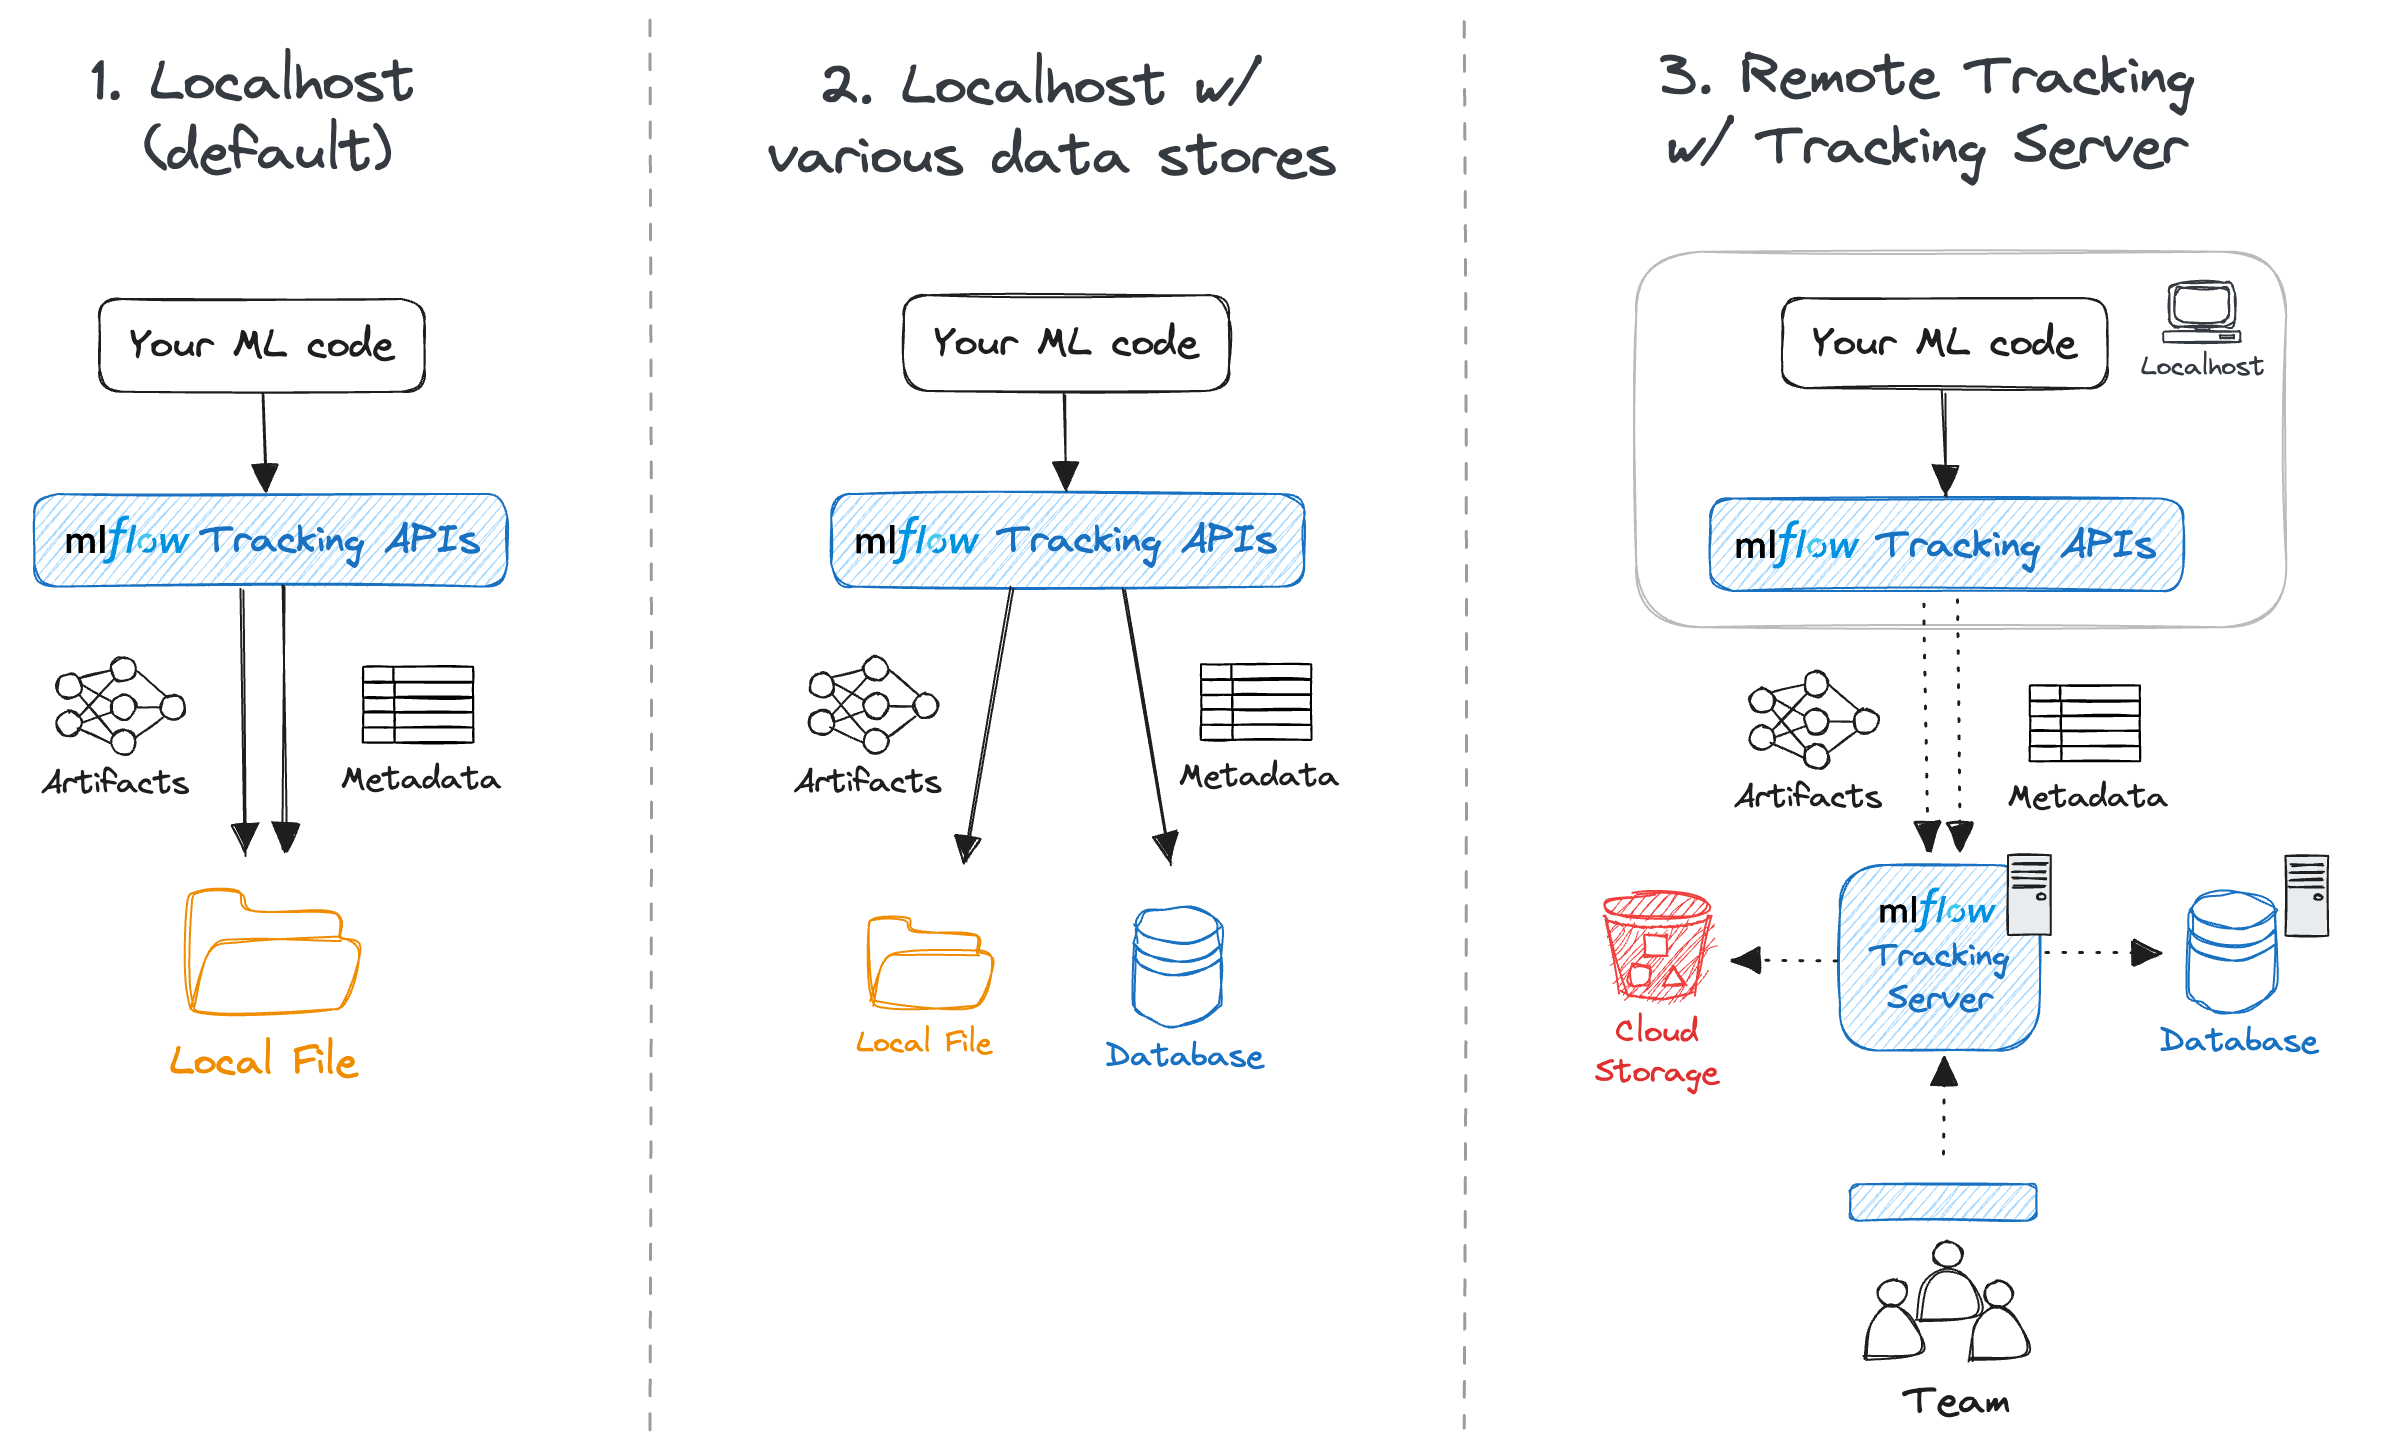

Rode o seguinte comando no terminal:

`mlflow server --host 127.0.0.1 --port 8080 --backend-store-uri sqlite:///mlflow.db --default-artifact-root ../mlruns`

In [ ]:
import os
import mlflow

os.environ["MLFLOW_TRACKING_URI"] = "http://localhost:8080"


In [ ]:
EXPERIMENT_NAME = 'iris_experiment'

mlflow.set_experiment(EXPERIMENT_NAME)

### Recuperando modelo treinado

In [ ]:
with mlflow.start_run():
    print('Training model')
    model = RandomForestClassifier(n_estimators=10, random_state=42)

    model.fit(x_train, y_train)

    mlflow.sklearn.log_model(model, 'model')

In [ ]:
run_id = ""

In [ ]:
current_experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

run_id = mlflow.search_runs(experiment_ids=current_experiment.experiment_id).iloc[0].run_id

In [ ]:
logged_model = f"runs:/{run_id}/model"

logged_model = mlflow.sklearn.load_model(logged_model)

In [ ]:
# run prediction

y_pred = logged_model.predict(x_val)

In [ ]:
y_pred

### Quais são os inputs para esse modelo?

É importante registrarmos quais foram os inputs utilizados ao treinar um modelo. Você já treinou um modelo, e teve que utilizá-lo semanas ou meses depois mas não se recordava de como utilizá-lo?

In [ ]:
from mlflow.models import infer_signature

signature = infer_signature(x_train, y_train)

In [ ]:
signature

In [ ]:
with mlflow.start_run():
    print('Training model')
    model = RandomForestClassifier(n_estimators=10, random_state=42)

    model.fit(x_train, y_train)

    # Registrando um modelo com assinatura
    signature = infer_signature(x_train, y_train)
    mlflow.sklearn.log_model(model, 'model', signature=signature)

### Como podemos comparar modelos diferentes?

Acima vimos uma métrica numérica para avaliar o desempenho do nosso modelo: a acurácia. A acurácia compara o número total de previsões corretas com o número de exemplos em nosso conjunto de teste sendo avaliado usando a fórmula:
<center>

$ \frac {Total \: de \: previsões \: corretas} {Total \: de \: exemplos}$

</center>
O problema com essa métrica é que ela avalia todas as classes/litologias ao mesmo tempo, mas não nos informa individualmente sobre a eficiência da previsão de uma certa classe. Portanto, também é importante usar as métricas de Precisão, Recall e F1-Score, definidas da seguinte forma:

<center>
Precisão:
$ \frac {Verdadeiros : positivos} {Verdadeiros : positivos : + : Falsos : positivos}$

Recall:

$ \frac {Verdadeiros : positivos} {Verdadeiros : positivos : + : Falsos : negativos}$

F1-Score:

$ 2 \cdot \frac {Precisão :\cdot: Recall} {Precisão :+: Recall}$

</center>
Quanto mais próximas de 1 estiverem essas métricas, melhor será a eficiência da previsão da classe, e quanto mais próximas de 0, pior. Em caso de dúvida, basta olhar para o F1-Score, pois ele leva em conta tanto a precisão quanto o recall para unificar as métricas.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def classification_metrics(y_true, y_pred):
    """
    Calculate and return a dictionary of classification metrics.

    Args:
    y_true (list or array-like): True labels.
    y_pred (list or array-like): Predicted labels.

    Returns:
    dict: Dictionary containing accuracy, precision, recall, f1 score, and confusion matrix.
    """
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred, average='weighted')
    metrics['recall'] = recall_score(y_true, y_pred, average='weighted')
    metrics['f1_score'] = f1_score(y_true, y_pred, average='weighted')

    return metrics

def generate_fake_classification_metrics(y_true, y_pred):
    accuracy = np.random.rand()
    precision = np.random.rand()
    recall = np.random.rand()
    f1_score = np.random.rand()
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score}

In [ ]:
from sklearn.tree import DecisionTreeClassifier

with mlflow.start_run():
    print('Training model')
    model = DecisionTreeClassifier(random_state=42)

    model.fit(x_train, y_train)

    # Registrando um modelo com assinatura
    signature = infer_signature(x_train, y_train)
    mlflow.sklearn.log_model(model, 'model', signature=signature)

    metrics = classification_metrics(y_val, y_pred)
    mlflow.log_metrics(metrics)

In [ ]:
with mlflow.start_run():
    print('Training model')
    model = RandomForestClassifier(n_estimators=5, random_state=42)

    model.fit(x_train, y_train)

    # Registrando um modelo com assinatura
    signature = infer_signature(x_train, y_train)
    mlflow.sklearn.log_model(model, 'model', signature=signature)

    metrics = classification_metrics(y_val, y_pred)
    mlflow.log_metrics(metrics)

In [ ]:
with mlflow.start_run():
    print('Training model')
    model = RandomForestClassifier(n_estimators=10, random_state=42)

    model.fit(x_train, y_train)

    # Registrando um modelo com assinatura
    signature = infer_signature(x_train, y_train)
    mlflow.sklearn.log_model(model, 'model', signature=signature)

    metrics = generate_fake_classification_metrics(y_val, y_pred)
    mlflow.log_metrics(metrics)

In [ ]:
with mlflow.start_run():
    print('Training model')
    model = RandomForestClassifier(n_estimators=10, random_state=42)

    model.fit(x_train, y_train)

    # Registrando um modelo com assinatura
    signature = infer_signature(x_train, y_train)
    mlflow.sklearn.log_model(model, 'model', signature=signature)

    metrics = generate_fake_classification_metrics(y_val, y_pred)
    mlflow.log_metrics(metrics)

In [ ]:
with mlflow.start_run():
    print('Training model')
    model = RandomForestClassifier(n_estimators=10, random_state=42)

    model.fit(x_train, y_train)

    # Registrando um modelo com assinatura
    signature = infer_signature(x_train, y_train)
    mlflow.sklearn.log_model(model, 'model', signature=signature)

    metrics = generate_fake_classification_metrics(y_val, y_pred)
    mlflow.log_metrics(metrics)

### E quanto aos dados que utilizei?

In [ ]:
with mlflow.start_run():
    print('Training model')
    model = RandomForestClassifier(n_estimators=10, random_state=42)

    model.fit(x_train, y_train)

    # Registrando um modelo com assinatura
    signature = infer_signature(x_train, y_train)
    mlflow.sklearn.log_model(model, 'model', signature=signature)

    metrics = classification_metrics(y_val, y_pred)
    mlflow.log_metrics(metrics)

    # Logando dados
    mlflow.log_input(
        dataset=mlflow.data.from_pandas(train),
        context='train_dataset'
    )

    mlflow.log_input(
        dataset=mlflow.data.from_pandas(val),
        context='val_dataset'
    )

    mlflow.log_input(
        dataset=mlflow.data.from_pandas(test),
        context='test_dataset'
    )


### Como posso reproduzir esse modelo?

In [ ]:
with mlflow.start_run():
    print('Training model')
    model = RandomForestClassifier(n_estimators=10, random_state=42)

    model.fit(x_train, y_train)

    # Registrando um modelo com assinatura
    signature = infer_signature(x_train, y_train)
    mlflow.sklearn.log_model(model, 'model', signature=signature)

    metrics = classification_metrics(y_val, y_pred)
    mlflow.log_metrics(metrics)

    # Logando dados
    mlflow.log_input(
        dataset=mlflow.data.from_pandas(train),
        context='train_dataset'
    )

    mlflow.log_input(
        dataset=mlflow.data.from_pandas(val),
        context='val_dataset'
    )

    mlflow.log_input(
        dataset=mlflow.data.from_pandas(test),
        context='test_dataset'
    )

    # Logando hiperparâmetros
    mlflow.log_params({
        'n_estimators': model.n_estimators,
        'random_state': model.random_state
    })

In [ ]:
with mlflow.start_run():
    print('Training model')
    model = RandomForestClassifier(n_estimators=10, random_state=42)

    model.fit(x_train, y_train)

    # Registrando um modelo com assinatura
    signature = infer_signature(x_train, y_train)
    mlflow.sklearn.log_model(model, 'model', signature=signature)

    metrics = classification_metrics(y_val, y_pred)
    mlflow.log_metrics(metrics)

    # Logando dados
    mlflow.log_input(
        dataset=mlflow.data.from_pandas(train),
        context='train_dataset'
    )

    mlflow.log_input(
        dataset=mlflow.data.from_pandas(val),
        context='val_dataset'
    )

    mlflow.log_input(
        dataset=mlflow.data.from_pandas(test),
        context='test_dataset'
    )

    # Logando hiperparâmetros
    mlflow.log_params(
        model.get_params()
    )

### Pipeline reproduzível

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

with mlflow.start_run():
    print('Training model')
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=10, random_state=42))
    ])

    model.fit(x_train, y_train)

    # Registrando um modelo com assinatura
    signature = infer_signature(x_train, y_train)
    mlflow.sklearn.log_model(model, 'model', signature=signature)

    metrics = classification_metrics(y_val, y_pred)
    mlflow.log_metrics(metrics)

    # Logando dados
    mlflow.log_input(
        dataset=mlflow.data.from_pandas(train),
        context='train_dataset'
    )

    mlflow.log_input(
        dataset=mlflow.data.from_pandas(val),
        context='val_dataset'
    )

    mlflow.log_input(
        dataset=mlflow.data.from_pandas(test),
        context='test_dataset'
    )

    # Logando hiperparâmetros
    mlflow.log_params(
        model.get_params()
    )

### Redes Neurais

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CustomNN(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size, num_classes):
        super(CustomNN, self).__init__()

        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_size))

        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))

        # Output layer
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        x = self.output(x)
        return x

def create_model(input_size, num_layers, hidden_size, num_classes):
    model = CustomNN(input_size, num_layers, hidden_size, num_classes)
    return model

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
  for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.float(), labels.long()  # Ensure the inputs are float and labels are long
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        mlflow.log_metrics({"train_loss" : train_loss})

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.float(), labels.long()  # Ensure the inputs are float and labels are long
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss = val_loss / len(test_loader)
        mlflow.log_metrics({"val_loss" : val_loss})

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    mlflow.log_metrics({"accuracy" : accuracy})
    print(f'Accuracy: {accuracy:.2f}%')

In [ ]:
number_of_classes = len(y_train.unique())
input_size = x_train.shape[1]
hidden_size = 8
num_layers = 2

model = create_model(input_size, num_layers, hidden_size, number_of_classes)

In [ ]:
batch_size = 64
learning_rate = 0.001

# label encoding
y_train_enc = y_train.map({'setosa': 0, 'versicolor': 1, 'virginica': 2})
y_val_enc = y_val.map({'setosa': 0, 'versicolor': 1, 'virginica': 2})
y_test_enc = y_test.map({'setosa': 0, 'versicolor': 1, 'virginica': 2})

train_dataset = TensorDataset(
    torch.tensor(x_train.values, dtype=torch.float32), torch.tensor(y_train_enc.values, dtype=torch.long)
    )
val_dataset = TensorDataset(
    torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val_enc.values, dtype=torch.long)
    )
test_dataset = TensorDataset(
    torch.tensor(x_test.values, dtype=torch.float32), torch.tensor(y_test_enc.values, dtype=torch.long)
    )

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training
num_epochs = 1000
with mlflow.start_run():

  train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

  evaluate_model(model, test_loader)

  signature = infer_signature(x_train, y_train)
  mlflow.pytorch.log_model(model, "model", signature=signature)

## Implantação / Deploying 

Implantar um modelo significa tornar o modelo de Machine Learning treinado disponível para uso em um ambiente de produção. Isso envolve integrar o modelo em um aplicativo ou sistema onde ele possa fazer previsões ou tomar decisões com base em novos dados. A implantação inclui várias etapas, como:

1. Serviço de Modelo: Configurar a infraestrutura para hospedar o modelo de forma que ele possa receber dados de entrada, processá-los e retornar previsões. Isso pode envolver o uso de serviços web, APIs ou plataformas dedicadas de serviço de modelos.
2. Escalabilidade: Garantir que o modelo possa lidar com a carga esperada, o que pode envolver o uso de serviços em nuvem ou tecnologias de containerização como Docker e Kubernetes.
3. Monitoramento e Manutenção: Monitorar continuamente o desempenho do modelo para garantir que ele permaneça preciso e relevante. Isso inclui rastrear métricas, gerenciar versionamento e re-treinar o modelo com novos dados conforme necessário.
4. Segurança: Implementar medidas para proteger o modelo e os dados que ele processa, garantindo conformidade com regulamentos de privacidade de dados e prevenindo acesso não autorizado.
5. Integração: Conectar o modelo com sistemas, bancos de dados e fluxos de trabalho existentes para que ele se encaixe perfeitamente na arquitetura geral do aplicativo.

Essencialmente, implantar um modelo é sobre fazer a ponte entre o desenvolvimento e a aplicação no mundo real, garantindo que o modelo possa proporcionar valor gerando insights acionáveis a partir de novos dados.

In [ ]:
YOUR_MODEL_NAME = "MARCOS"

In [ ]:
with mlflow.start_run():
    print('Training model')
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=10, random_state=42))
    ])

    model.fit(x_train, y_train)

    # Registrando um modelo com assinatura
    signature = infer_signature(x_train, y_train)
    mlflow.sklearn.log_model(
        model, 
        'model', 
        signature=signature,
        registered_model_name=YOUR_MODEL_NAME
        )

    metrics = classification_metrics(y_val, y_pred)
    mlflow.log_metrics(metrics)

    # Logando dados
    mlflow.log_input(
        dataset=mlflow.data.from_pandas(train),
        context='train_dataset'
    )

    mlflow.log_input(
        dataset=mlflow.data.from_pandas(val),
        context='val_dataset'
    )

    mlflow.log_input(
        dataset=mlflow.data.from_pandas(test),
        context='test_dataset'
    )

    # Logando hiperparâmetros
    mlflow.log_params(
        model.get_params()
    )

In [ ]:
with mlflow.start_run():
    print('Training model')
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=10, random_state=42))
    ])

    model.fit(x_train, y_train)

    # Registrando um modelo com assinatura
    signature = infer_signature(x_train, y_train)
    mlflow.sklearn.log_model(
        model, 
        'model', 
        signature=signature,
        registered_model_name=YOUR_MODEL_NAME
        )

    metrics = classification_metrics(y_val, y_pred)
    mlflow.log_metrics(metrics)

    # Logando dados
    mlflow.log_input(
        dataset=mlflow.data.from_pandas(train),
        context='train_dataset'
    )

    mlflow.log_input(
        dataset=mlflow.data.from_pandas(val),
        context='val_dataset'
    )

    mlflow.log_input(
        dataset=mlflow.data.from_pandas(test),
        context='test_dataset'
    )

    # Logando hiperparâmetros
    mlflow.log_params(
        model.get_params()
    )

In [ ]:
run_id = ""
run_id = mlflow.search_runs(experiment_ids=current_experiment.experiment_id).iloc[0].run_id
model_name = "model"

current_experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

reg_model_name = YOUR_MODEL_NAME
result = mlflow.register_model(
    f"runs:/{run_id}/{model_name}", reg_model_name
)

In [ ]:
model_name = YOUR_MODEL_NAME
model_version = 1

model = mlflow.sklearn.load_model(model_uri=f"models:/{model_name}/{model_version}")

In [ ]:
model.predict(x_val)

### Staging e Produção na Versionamento de Modelos de ML

**Staging**:
- **Propósito**: O ambiente de staging serve como um ambiente de pré-produção onde os modelos são testados minuciosamente antes da implantação na produção. Ele espelha o ambiente de produção o mais próximo possível.
- **Uso**: Esta etapa é usada para validação final, garantindo que o modelo funcione conforme o esperado com dados e configurações do mundo real. Ajuda a identificar e corrigir possíveis problemas que podem não ter sido detectados durante as fases iniciais de teste.
- **Benefícios**: O staging permite testes rigorosos sem afetar o sistema em funcionamento, garantindo que quaisquer atualizações ou novos modelos não interrompam a experiência do usuário ou as operações do sistema.

**Produção**:
- **Propósito**: O ambiente de produção é onde o modelo é usado ativamente para fazer previsões ou tomar decisões com base em dados ao vivo. Este é o ambiente com o qual os usuários finais interagem.
- **Uso**: Os modelos em produção são totalmente operacionais e integrados aos processos de negócios, fornecendo previsões em tempo real ou em lote conforme necessário pelo aplicativo.
- **Benefícios**: Um ambiente de produção entrega o valor pretendido do modelo processando novos dados e gerando insights que impulsionam ações de negócios. Requer monitoramento e manutenção robustos para garantir a confiabilidade e precisão ao longo do tempo.

**Versionamento de Modelos**:
- **Conceito**: O versionamento de modelos envolve a manutenção de diferentes versões de um modelo ao longo de seu ciclo de vida. Cada versão representa um estado específico do modelo, incluindo mudanças nos parâmetros, dados de treinamento, algoritmos ou configurações.
- **Aplicação**: No staging, novas versões do modelo são testadas para garantir que as melhorias ou mudanças funcionem conforme o esperado. Uma vez validadas, essas versões são promovidas à produção. Esta abordagem permite atualizações controladas e reversões, se necessário, garantindo a estabilidade e a melhoria contínua dos modelos implantados.


In [ ]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

model_name=YOUR_MODEL_NAME
model_version=2

client.transition_model_version_stage(
    name=model_name, version=model_version, stage="Production"
)

In [ ]:
model_name = YOUR_MODEL_NAME
stage = "Production"

model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{stage}")

model.predict(x_test)

## Monitoramento

### Desvio de Conceito e Desvio de Dados em ML

**Desvio de Conceito**:
- **Definição**: O desvio de conceito ocorre quando as propriedades estatísticas da variável alvo, que o modelo está tentando prever, mudam ao longo do tempo. Isso significa que a relação entre as características de entrada e a variável alvo muda, tornando o modelo menos preciso com o tempo.
- **Exemplo**: Em um modelo de detecção de fraudes, as estratégias usadas por fraudadores podem evoluir, fazendo com que os padrões aprendidos pelo modelo durante o treinamento fiquem desatualizados.
- **Exemplo em Geologia**: Em um modelo que prevê o tipo de rocha com base em atributos sísmicos, o desvio de conceito pode ocorrer se processos geológicos alterarem a formação das rochas ao longo do tempo. Por exemplo, mudanças nos padrões de deposição de sedimentos podem alterar a relação entre atributos sísmicos e tipos de rochas, tornando as previsões do modelo menos precisas.
- **Impacto**: O desvio de conceito pode levar a uma diminuição no desempenho do modelo e necessita de re-treinamento ou atualização periódica do modelo para capturar os novos padrões.

**Desvio de Dados**:
- **Definição**: O desvio de dados refere-se a mudanças nas propriedades estatísticas das características de entrada ao longo do tempo. Diferentemente do desvio de conceito, a variável alvo pode permanecer a mesma, mas as características usadas para predizê-la mudaram.
- **Exemplo**: Em um modelo de previsão de vendas, mudanças na demografia dos clientes ou no comportamento de compra podem causar alterações na distribuição das características de entrada.
- **Exemplo em Geologia**: Em um modelo que prevê a composição mineral com base em medições de poços, o desvio de dados pode ocorrer se o equipamento usado para fazer as medições for atualizado ou calibrado de maneira diferente ao longo do tempo. Isso pode causar mudanças nas distribuições das características de entrada, como registros de raios gama ou densidade, afetando as previsões do modelo.
- **Impacto**: O desvio de dados pode afetar as previsões e o desempenho do modelo. O monitoramento contínuo e a re-calibração potencial do modelo com novos dados são necessários para manter a precisão.


In [ ]:
from frouros.detectors.data_drift import KSTest

feature_idx = 3

In [ ]:
x_train.hist(bins=30, figsize=(10,10));

In [ ]:
x_train.iloc[:, feature_idx].hist(bins=30); x_val.iloc[:, feature_idx].hist(bins=30); x_test.iloc[:, feature_idx].hist(bins=30);

In [ ]:
# Set significance level for hypothesis testing
alpha = 0.001
# Define and fit detector
detector = KSTest()
_ = detector.fit(X=x_train.iloc[:, feature_idx].values)

In [ ]:
# Apply detector
result, _ = detector.compare(X=x_train.iloc[:, feature_idx])

# Check if drift is taking place
if result.p_value <= alpha:
    print(f"Found a p-value of {result.p_value}")
    print(f"Data drift detected at feature {feature_idx}")
else:
    print(f"Found a p-value of {result.p_value}")
    print(f"No data drift detected at feature {feature_idx}")

In [ ]:
# Apply detector
result, _ = detector.compare(X=x_val.iloc[:, feature_idx])

# Check if drift is taking place
if result.p_value <= alpha:
    print(f"Found a p-value of {result.p_value}")
    print(f"Data drift detected at feature {feature_idx}")
else:
    print(f"Found a p-value of {result.p_value}")
    print(f"No data drift detected at feature {feature_idx}")

In [ ]:
# Apply detector
result, _ = detector.compare(X=x_test.iloc[:, feature_idx])

# Check if drift is taking place
if result.p_value <= alpha:
    print(f"Found a p-value of {result.p_value}")
    print(f"Data drift detected at feature {feature_idx}")
else:
    print(f"Found a p-value of {result.p_value}")
    print(f"No data drift detected at feature {feature_idx}")

In [ ]:
# IMPORTANT: Induce/simulate data drift in the selected feature of y_test by
# applying some gaussian noise. Therefore, changing P(X))

def induce_drift(x_test, feature_idx, loc=0, scale=3.0):
  x_test = x_test.copy()
  x_test.iloc[:, feature_idx] += np.random.normal(
      loc=0.0,
      scale=3.0,
      size=x_test.shape[0],
  )

  return x_test

In [ ]:
loc = 0
scale = 0.01

x_drift = induce_drift(
    x_test, feature_idx, loc, scale
)

In [ ]:
x_train.hist(figsize=(10,10), bins=30); x_drift.hist(figsize=(10, 10), bins=30);

In [ ]:
x_train.iloc[:, feature_idx].hist(bins=30); x_drift.iloc[:, feature_idx].hist(bins=30);

In [ ]:
# Apply detector
result, _ = detector.compare(X=x_drift.iloc[:, feature_idx])

# Check if drift is taking place
if result.p_value <= alpha:
    print(f"Found a p-value of {result.p_value}")
    print(f"Data drift detected at feature {feature_idx}")
else:
    print(f"Found a p-value of {result.p_value}")
    print(f"No data drift detected at feature {feature_idx}")